# Defect_Classification_CNN

* Written by: Angelo D. Bonzanini and Ketong Shao
* Date: June-July 2021

<< Code Desctription >>

## Imports

In [2]:
# General
import numpy as np
import matplotlib.pyplot as plt
import os

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import Model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
execution_path = '/content/gdrive/MyDrive/Colab Notebooks/Code/ML-for-plasmas'

# import tensorflow_addons as tfa
# # ImageAI
# from imageai.Detection import ObjectDetection
# from PIL import Image as im
# from PIL import ImageOps
# from matplotlib import cm
# import pandas as pd

Mounted at /content/gdrive


## Load pre-processed data

In [3]:
xTrain = np.load(execution_path+'/../Data/xTrain.npy')
yTrain = np.load(execution_path+'/../Data/yTrain.npy')
xVal = np.load(execution_path+'/../Data/xVal.npy')
yVal = np.load(execution_path+'/../Data/yVal.npy')

## Define a class containing all the parameters

In [4]:
class Parameters:
    def __init__(self):
        self.Ntrain = xTrain.shape[0]
        self.imgSize = [xTrain.shape[1],xTrain.shape[2]]
        self.dropoutRate = 0.01
        

p = Parameters();

23780
xTrain shape (each item in list) =  (140, 140, 3)


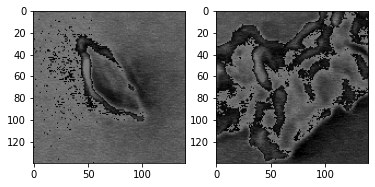

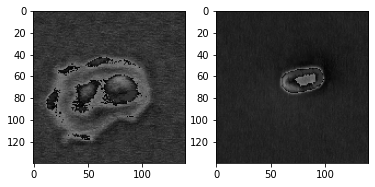

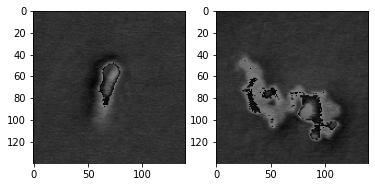

In [5]:
print(len(xTrain))
print('xTrain shape (each item in list) = ', xTrain[0].shape)
for i in range(0, 3):
    plt.subplot(121)
    plt.imshow(xTrain[i])
    plt.subplot(122)
    plt.imshow(xVal[i])
    plt.show()

In [6]:
xTrain = np.load(execution_path+'/../Data/xTrain.npy')
xVal = np.load(execution_path+'/../Data/xVal.npy')

NORMALIZATION = xTrain.max()
trainImagesRGB = np.concatenate(xTrain/NORMALIZATION, axis=0).reshape(-1, p.imgSize[0], p.imgSize[1], 3)
valImagesRGB = np.concatenate(xVal/NORMALIZATION, axis=0).reshape(-1, p.imgSize[0], p.imgSize[1], 3)
del xTrain, xVal

In [7]:
yTrainInt = (yTrain.argmax(axis=1)).reshape(-1,1)
yValInt = (yVal.argmax(axis=1)).reshape(-1,1)
print(yTrainInt.shape)

ss = 0
for i in range(0, 8):
  ll = len(np.where(yTrainInt==i)[0])
  print(ll)

(23780, 1)
6178
6313
2034
793
2778
1913
662
3109


In [8]:
idxTrain = np.concatenate([np.where(yTrainInt==0)[0], np.where(yTrainInt==1)[0]], axis=0)
idxVal = np.concatenate([np.where(yValInt==0)[0], np.where(yValInt==1)[0]], axis=0)

trainImagesRGB = trainImagesRGB[idxTrain, :, :]
valImagesRGB = trainImagesRGB[idxVal, :, :]

yTrainBinary = yTrainInt[idxTrain].reshape(-1,1)
yValBinary = yValInt[idxVal].reshape(-1,1)

In [9]:
print(trainImagesRGB.shape)
print(yTrainBinary.shape)
print(valImagesRGB.shape)
print(yValBinary.shape)

(12491, 140, 140, 3)
(12491, 1)
(49, 140, 140, 3)
(49, 1)


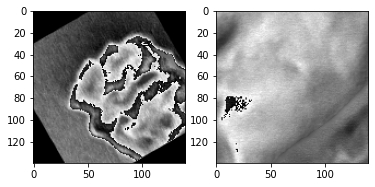

------ Training Images (RGB) ------ 
Shape =  (12491, 140, 140, 3)
Min and Max Values =  [0.0, 1.0]
------ Training Labels ------ 
Shape =  (23780, 8)
------ Validation Images (RGB) ------ 
Min and Max Values =  [0.0, 1.0]
Shape =  (49, 140, 140, 3)
------ Validation Labels ------ 
Shape =  (100, 8)


In [10]:
plt.subplot(121)
plt.imshow(trainImagesRGB[1,:,:])
plt.subplot(122)
plt.imshow(valImagesRGB[1,:,:])
plt.show()

# [print(i.shape, i.dtype) for i in model.inputs]
# [print(o.shape, o.dtype) for o in model.outputs]
# [print(l.name, l.input_shape, l.dtype) for l in model.layers]
print('------ Training Images (RGB) ------ ')
print('Shape = ', trainImagesRGB.shape)
print('Min and Max Values = ', [trainImagesRGB.min(), trainImagesRGB.max()])
print('------ Training Labels ------ ')
print('Shape = ', yTrain.shape)
print('------ Validation Images (RGB) ------ ')
print('Min and Max Values = ', [valImagesRGB.min(), valImagesRGB.max()])
print('Shape = ', valImagesRGB.shape)
print('------ Validation Labels ------ ')
print('Shape = ', yVal.shape)

## Build the CNN model

### Input Layer
* 224x224 RGB image (3 channels)

### 1st Convolutional Block
* 2 convolutional layers
    * Filters: 64; Pixel size: 3x3; Stride: 1; Activation function: ReLU
* 1 max-pooling layer
    * Pixel size: 2x2; Stride: 2
    
### 2nd Convolutional Block
* 2 convolutional layers
    * Filters: 128; Pixel size: 3x3; Stride: 1; Activation function: ReLU
* 1 max-pooling layer
    * Pixel size: 2x2; Stride: 2
    
### 3rd Convolutional Block
* 3 convolutional layers
    * Filters: 256; Pixel size: 3x3; Stride: 1; Activation function: ReLU
* 1 max-pooling layer
    * Pixel size: 2x2; Stride: 2

### 4th & 5th Convolutional Blocks
* 3 convolutional layers
    * Filters: 512; Pixel size: 3x3; Stride: 1; Activation function: ReLU
* 1 max-pooling layer
    * Pixel size: 2x2; Stride: 2
    
### 1st Fully-connected Layer
* 4096 nodes
* ReLU activation function
* 50% dropout rate

### 2nd Fully-connected Layer
* 4096 nodes
* ReLU activation function
* 50% dropout rate

### Output Layer
* 8 nodes
* Softmax activation function

In [11]:
checkpoint_path = execution_path + "/Defect_Classification/cnn_model_trained/cnn_model_normalized_X_try2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
p.dropoutRate = 0.01 # 0.01 --> 95% test accuracy
class CNN():
    def buildModel(self):
        # Input structure as a placeholder
        CNNinput = Input(shape =(140,140, 3))

        # 1st Convolutional block
        x = Conv2D(filters=64, kernel_size = (3, 3), strides = 1, padding = 'same', 
                   activation='relu')(CNNinput)
        x = Conv2D(filters=64, kernel_size = (3, 3), strides = 1, padding = 'same', 
                   activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')(x)

        # 2nd Convolutional block
        for i in range(0, 2):
            x = Conv2D(filters=128, kernel_size = (3, 3), strides = 1, padding = 'same', 
                       activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')(x)

        # 3rd Convolutional block
        for i in range(0, 3):
            x = Conv2D(filters=256, kernel_size = (3, 3), strides = 1, padding = 'same', 
                       activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')(x)

        # 4th Convolutional block
        for i in range(0, 3):
            x = Conv2D(filters=512, kernel_size = (3, 3), strides = 1, padding = 'same', 
                       activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')(x)

        # 5th Convolutional block
        for i in range(0, 2):
            x = Conv2D(filters=512, kernel_size = (3, 3), strides = 1, padding = 'same', 
                       activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')(x)

        # Fully connected layers
        x = Flatten()(x)
        for i in range(0,3):
            x = Dense(units = 4096, activation ='relu')(x) 
            x = Dropout(p.dropoutRate)(x)
        # CNNoutput = Dense(units = 1, activation ='softmax')(x)
        CNNoutput = Dense(units = 1, activation ='sigmoid')(x)

        # Create model
        model = Model(inputs = CNNinput, outputs = CNNoutput)
        return model
    
    def trainCNN(self, model, xTrain, yTrain, xVal, yVal):
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
        
        # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
        
        history = model.fit(xTrain, yTrain, epochs=10, 
                            validation_data=(xVal, yVal))
        return history

In [12]:
# Instantiate object
cnn = CNN()
model = cnn.buildModel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140, 140, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 140, 140, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 140, 140, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 70, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 70, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 70, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 128)       0     

## Train the CNN

In [19]:
# Train the CNN
# history = cnn.trainCNN(model, trainImagesRGB[0:1000, :, :, :], yTrainBinary[0:1000], valImagesRGB, yValBinary)

# history = cnn.trainCNN(model, trainImagesRGB, yTrainBinary, valImagesRGB, yValBinary)
# cnnModel = history.model
# cnnModel.save(execution_path+'/Defect_Classification/cnn_model_trained/cnn_normalized_X_classes_0_1')

Epoch 1/10
391/391 [==============================] - 973s 2s/step - loss: 38525.2812 - accuracy: 0.5463 - val_loss: 0.7209 - val_accuracy: 0.5102
Epoch 2/10
391/391 [==============================] - 966s 2s/step - loss: 0.4617 - accuracy: 0.8135 - val_loss: 0.7755 - val_accuracy: 0.5714
Epoch 3/10
391/391 [==============================] - 964s 2s/step - loss: 0.4899 - accuracy: 0.7525 - val_loss: 0.6972 - val_accuracy: 0.4694
Epoch 4/10
391/391 [==============================] - 968s 2s/step - loss: 0.4052 - accuracy: 0.8349 - val_loss: 2.5387 - val_accuracy: 0.5102
Epoch 5/10
391/391 [==============================] - 965s 2s/step - loss: 0.2560 - accuracy: 0.9112 - val_loss: 1.8729 - val_accuracy: 0.4490
Epoch 6/10
391/391 [==============================] - 965s 2s/step - loss: 0.2232 - accuracy: 0.9189 - val_loss: 2.3849 - val_accuracy: 0.5102
Epoch 7/10
391/391 [==============================] - 961s 2s/step - loss: 0.2152 - accuracy: 0.9227 - val_loss: 2.0412 - val_accuracy: 0.

In [15]:
# Load a previously trained model
model.load_weights(execution_path+'/Defect_Classification/cnn_model_trained/cnn_normalized_X_classes_0_1')
cnnModel = model

In [16]:
# del valImagesRGB, yVal#, trainImagesRGB, yTrain
xTest = np.load(execution_path+'/../Data/xTest.npy')
yTest = np.load(execution_path+'/../Data/yTest.npy')
yTestInt = (yTest.argmax(axis=1)).reshape(-1,1)
idxTest = np.concatenate([np.where(yTestInt==0)[0], np.where(yTestInt==1)[0]], axis=0)

testImagesRGB = np.concatenate(xTest/NORMALIZATION, axis=0).reshape(-1, p.imgSize[0], p.imgSize[1], 3)
testImagesRGB = testImagesRGB[idxTest, :, :]
yTestBinary = yTestInt[idxTest].reshape(-1, 1)
del xTest

In [32]:
def classFromBinaryProb(y, pThreshold):
  idx0 = np.where(y<pThreshold)[0]
  idx1 = np.where(y>=pThreshold)[0]
  y[idx0] = 0
  y[idx1] = 1
  yBinary = y
  return yBinary

In [17]:
yPredTrain = cnnModel.predict(trainImagesRGB)
yPred = cnnModel.predict(testImagesRGB)

yPredClass = classFromBinaryProb(yPred, 0.5)
yPredTrainClass = classFromBinaryProb(yPredTrain, 0.5)

yTestClass = yTest.argmax(axis=1)
yTrainClass = yTrain[idxTrain].argmax(axis=1)

<Figure size 600x400 with 0 Axes>

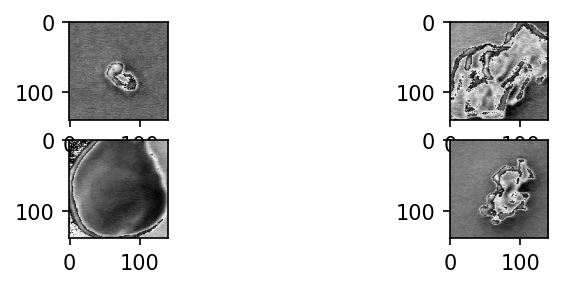

<Figure size 600x400 with 0 Axes>

In [19]:
plt.figure(dpi=150)
plt.subplot(421)
plt.imshow(testImagesRGB[0,:,:,:])
plt.subplot(422)
plt.imshow(testImagesRGB[1,:,:,:])
plt.subplot(423)
plt.imshow(testImagesRGB[5,:,:,:])
plt.subplot(424)
plt.imshow(testImagesRGB[10,:,:,:])

plt.figure(dpi=100)
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
# plt.legend()
# plt.show()

Train accuracy =  0.94692177
No. of Misclassified Training Points =  663
No. of Total Training Points =  12491
Test accuracy =  0.94629997
No. of Misclassified Test Points =  120
No. of Total Test Points =  2090


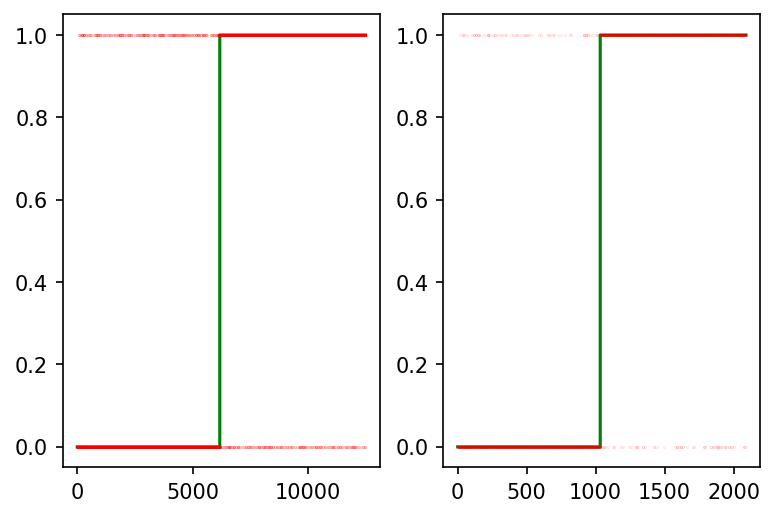

In [56]:
accuracyMetricFn = tf.keras.metrics.Accuracy()
accuracyMetricFn.update_state(yTrainBinary, yPredTrain)
print('Train accuracy = ', accuracyMetricFn.result().numpy())
print('No. of Misclassified Training Points = ', len(np.where(yTrainBinary!=yPredTrain)[0]))
print('No. of Total Training Points = ', yTrainBinary.shape[0])
accuracyMetricFn.update_state(yTestBinary, yPredClass)
print('Test accuracy = ', accuracyMetricFn.result().numpy())
print('No. of Misclassified Test Points = ', len(np.where(yTestBinary!=yPredClass)[0]))
print('No. of Total Test Points = ', yTestBinary.shape[0])


plt.figure(dpi=150)
plt.subplot(121)
plt.step(yTrainBinary, 'g')
plt.step(yPredTrainClass, 'r.', markersize=0.1)
plt.subplot(122)
plt.step(yTestBinary, 'g')
plt.step(yPredClass, 'r.', markersize=0.1)
plt.show()

In [45]:
def accuracyManual(yRealClass, yPredClass):
  Ntotal = yRealClass.shape[0]
  idx = np.where(yRealClass==yPredClass)[0]
  Ncorrect = len(idx)
  acc = Ncorrect*100.0/Ntotal
  return acc

acc = accuracyManual(yTestBinary, yPredClass)
print(acc)

94.25837320574162


# To Do:

* NORMALIZE images and retrain
* Convert categorical output variables to numbers $\rightarrow$ use SparseCategoricalCrossentropy
* Check whether predictions using the training data are different from each other
* Change CNN structure according to Jared's paper and retrain
* Use sigmoid activation function in last layer and crossentropy and re-train (binary classification)

## Old Code

### Run object detection algorithm (Later)

In [ ]:
'''
execution_path = os.getcwd()

detector = ObjectDetection()
# detector.setModelTypeAsRetinaNet()
# detector.setModelPath(os.path.join(execution_path , "resnet50_coco_best_v2.1.0.h5"))
detector.setModelTypeAsYOLOv3()
detector.setModelPath(os.path.join(execution_path , "pretrained-yolov3.h5"))
detector.loadModel()
# detections = detector.detectObjectsFromImage(input_image=os.path.join(execution_path, "defectImage.jpeg"), output_image_path=os.path.join(execution_path , "defectImageID.jpg"))
detections = detector.detectObjectsFromImage(input_type = "array", input_image=aaRGB, output_image_path=os.path.join(execution_path , "Defect_Images/defectImageID.jpg"))


for eachObject in detections:
    print(eachObject["name"] , " : " , eachObject["percentage_probability"] )
    
'''

In [ ]:
# Load
# [...]

# Outlier detection using clustering?
# [...]

# Data augmentation by roating 60 degrees
# [...]
# rotate = tfa.image.rotate(img, tf.constant(np.pi/3))
# visualize(image, rotated)
